In [26]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import os
import csv
from PIL import Image
import matplotlib.pyplot as plt

In [27]:
transform=transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
])

In [28]:
class SampleDataset(Dataset):
    def __init__(self, image_dir, conductivities, transform=None):
        self.conds=conductivities
        self.samples=[]
        for filename in sorted(os.listdir(image_dir), key=lambda x: int(x[:-5])):
            self.samples.append(transform(Image.open(image_dir+filename)))
        self.samples=torch.stack(tensors=self.samples)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        return self.samples[index], self.conds[index]
    
    def to(self, device):
        self.samples=self.samples.to(device)
        self.conds=self.conds.to(device)

In [29]:
with open('./data/data.csv') as f:
    reader=csv.reader(f)
    d=list(reader)
conductivities=torch.tensor(data=[float(x[2]) for x in d[1:]], dtype=torch.float32)
volPer=torch.tensor(data=[float(x[1]) for x in d[1:]], dtype=torch.float32)
conductivities
dataset=SampleDataset('./data/samples/', conductivities, transform)
dataset.to('cuda')

In [31]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_filters, image_size):
        super(CNN, self).__init__()

        #calculating image resolution as we progress through model
        image_size_1=(image_size-8+1)//2
        image_size_2=(image_size_1-4+1)//2
        self.conv=torch.nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=num_filters, kernel_size=(8, 8), stride=1),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.BatchNorm2d(num_features=num_filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=num_filters, out_channels=num_filters*2, kernel_size=(4, 4), stride=1),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.BatchNorm2d(num_features=num_filters*2),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(in_features=image_size_2*image_size_2*num_filters*2, out_features=150),
            nn.ReLU(inplace=True),
            # nn.Dropout(p=0.5),
            nn.Linear(in_features=150, out_features=84),
            nn.ReLU(inplace=True),
            # nn.Dropout(p=0.5),
            nn.Linear(in_features=84, out_features=1)
        )

    def forward(self, x):
        return self.conv(x)

In [32]:
model=CNN(1, 32, 160).to('cuda')
# model(dataset[:][0]).view(1024).shape

In [33]:
train_dataset, test_dataset=torch.utils.data.random_split(dataset=dataset, lengths=[0.8, 0.2])
len(train_dataset), len(test_dataset)
test_dataset[:][1]

tensor([1.2947, 1.1794, 1.1676, 1.1188, 1.3965, 1.3226, 1.4529, 1.2896, 1.3781,
        1.2289, 1.4898, 1.4984, 1.4007, 1.4123, 1.2589, 1.0626, 1.2732, 1.3532,
        1.4475, 1.4831, 1.2072, 1.0960, 1.4486, 1.3373, 1.4636, 1.4056, 1.2646,
        1.2171, 1.4890, 1.4943, 1.3625, 1.2320, 1.4200, 1.0848, 1.4916, 1.4420,
        1.4935, 1.4944, 1.4846, 1.4999, 1.0753, 1.4534, 1.3714, 1.4618, 1.3088,
        1.3444, 1.3437, 1.4289, 1.2498, 1.4371, 1.4554, 1.3175, 1.4902, 1.3260,
        1.4566, 1.5000, 1.2408, 1.1395, 1.2088, 1.0509, 1.2749, 1.3323, 1.3146,
        1.4187, 1.5064, 1.4845, 1.1843, 1.3759, 1.3994, 1.4019, 1.3895, 1.0376,
        1.4592, 1.1505, 1.3056, 1.4892, 1.4982, 1.0991, 1.4749, 1.4745, 1.5062,
        1.3083, 1.4544, 1.2423, 1.3943, 1.5047, 1.2696, 1.1175, 1.4917, 1.4014,
        1.4769, 1.2086, 1.3304, 1.0594, 1.3371, 1.2706, 1.4704, 1.3371, 1.0957,
        1.2449, 1.4651, 1.1694, 1.3473, 1.4983, 1.3723, 1.3910, 1.4766, 1.0110,
        1.3273, 1.2479, 1.2682, 1.0466, 

In [34]:
def train_CNN(train_data, model, loss_fn, optimizer, epochs):
    train_data, val_data=torch.utils.data.random_split(train_data, [0.8, 0.2])
    best_loss=2**63
    val_loss_history=[]
    train_loss_history=[]
    for epoch in range(epochs):
        dataloader=DataLoader(train_data, batch_size=32, shuffle=True)
        running_loss=0
        for batch in dataloader:
            inputs, labels=batch
            optimizer.zero_grad()
            pred=model(inputs)
            loss=loss_fn(pred, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()

        with torch.no_grad():
            val_dataloader=DataLoader(val_data)
            val_loss=0
            for batch in val_dataloader:
                inputs, labels=batch
                pred=model(inputs)
                loss=loss_fn(pred, labels.unsqueeze(1))
                val_loss+=loss.item()
            print(epoch, 'TRAINING LOSS:', running_loss/len(dataloader), 'VALIDATION LOSS:', val_loss/len(val_dataloader))
            val_loss_history.append(val_loss/len(val_dataloader))
            train_loss_history.append(running_loss/len(dataloader))
       
        if best_loss>running_loss/len(dataloader):
            best_loss=running_loss/len(dataloader)
            torch.save(model.state_dict(), "CNN_BEST1.pt")
    return val_loss_history, train_loss_history

In [36]:
val_loss, train_loss=train_CNN(train_dataset, model, torch.nn.MSELoss(), torch.optim.Adam(model.parameters(), lr=0.001), 300)

0 TRAINING LOSS: 4.284940682528984 VALIDATION LOSS: 0.1448090590491164
1 TRAINING LOSS: 0.049160453845702466 VALIDATION LOSS: 0.04138496730998562
2 TRAINING LOSS: 0.0082459916981558 VALIDATION LOSS: 0.021479285430484375
3 TRAINING LOSS: 0.005840908070760114 VALIDATION LOSS: 0.023256437400091937
4 TRAINING LOSS: 0.0045358473989402966 VALIDATION LOSS: 0.026756005804562704
5 TRAINING LOSS: 0.004011308391844588 VALIDATION LOSS: 0.023442356682874272
6 TRAINING LOSS: 0.0022066030983946155 VALIDATION LOSS: 0.020584172768694106
7 TRAINING LOSS: 0.0021540564817509483 VALIDATION LOSS: 0.025191069919406887
8 TRAINING LOSS: 0.0018809097236953676 VALIDATION LOSS: 0.02028847466634466
9 TRAINING LOSS: 0.001461209210988489 VALIDATION LOSS: 0.030828043325568242
10 TRAINING LOSS: 0.0016159007500391454 VALIDATION LOSS: 0.021475974463880183
11 TRAINING LOSS: 0.0016473566994093182 VALIDATION LOSS: 0.02007377755590455
12 TRAINING LOSS: 0.001261549544454153 VALIDATION LOSS: 0.0238651443885346
13 TRAINING LOS

In [12]:
transfer_model=tv.models.resnet18(pretrained=True)
transfer_model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
transfer_model.fc=nn.Sequential(
    nn.Linear(transfer_model.fc.in_features, 150),  
    nn.ReLU(),                             
    # nn.Dropout(0.3),                       
    nn.Linear(150, 84),
    nn.ReLU(inplace=True),
    # nn.Dropout(p=0.5),
    nn.Linear(in_features=84, out_features=1),
)

for param in transfer_model.parameters():
    param.requires_grad = False

for param in transfer_model.fc.parameters():
    param.requires_grad = True

transfer_model=transfer_model.to('cuda')

In [14]:
val_loss, train_loss=train_CNN(train_dataset, transfer_model, torch.nn.MSELoss(), torch.optim.Adam(transfer_model.parameters(), lr=0.001, weight_decay=1e-5), 1000)

0 TRAINING LOSS: 0.17628619110300428 VALIDATION LOSS: 0.033518038830511444
1 TRAINING LOSS: 0.03376701367752893 VALIDATION LOSS: 0.021188731213153848
2 TRAINING LOSS: 0.025269639101766404 VALIDATION LOSS: 0.0237267811522465
3 TRAINING LOSS: 0.021101762318894976 VALIDATION LOSS: 0.025230320947333587
4 TRAINING LOSS: 0.01676803215273789 VALIDATION LOSS: 0.020686740271270033
5 TRAINING LOSS: 0.015736441793186322 VALIDATION LOSS: 0.022663654397688776
6 TRAINING LOSS: 0.012692155759958993 VALIDATION LOSS: 0.030932261168869643
7 TRAINING LOSS: 0.01616014309582256 VALIDATION LOSS: 0.020586330659683558
8 TRAINING LOSS: 0.010728675384251844 VALIDATION LOSS: 0.02015175249826692
9 TRAINING LOSS: 0.011649307750520251 VALIDATION LOSS: 0.025063851510318255
10 TRAINING LOSS: 0.009779824720074734 VALIDATION LOSS: 0.02004786845220512
11 TRAINING LOSS: 0.008345693815499544 VALIDATION LOSS: 0.020057042890592132
12 TRAINING LOSS: 0.008313720868456932 VALIDATION LOSS: 0.020829305678491006
13 TRAINING LOSS:

ValueError: too many values to unpack (expected 2)

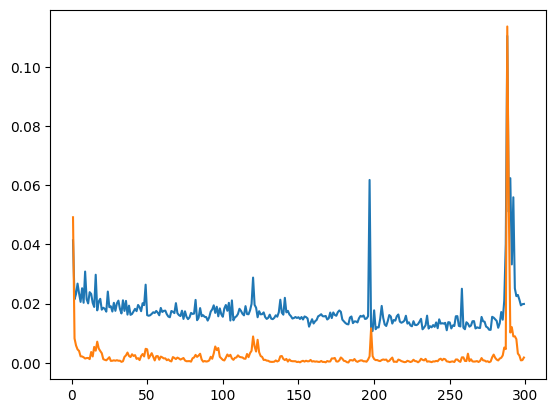

In [39]:
plt.plot(range(1,300), val_loss[1:])
plt.plot(range(1,300), train_loss[1:])

In [40]:
with torch.no_grad():
    pred=model(test_dataset[:][0])
    actual=test_dataset[:][1].unsqueeze(1)
for i in range(len(test_dataset)):
    print(pred[i].item(), actual[i].item(), pred[i].item()-actual[i].item())
print(nn.MSELoss()(pred, actual).item())

1.2034605741500854 1.2947278022766113 -0.09126722812652588
1.111383080482483 1.1793947219848633 -0.06801164150238037
1.1902989149093628 1.1676208972930908 0.022678017616271973
1.1274162530899048 1.1187950372695923 0.0086212158203125
1.3659127950668335 1.396453619003296 -0.030540823936462402
1.2298372983932495 1.3226308822631836 -0.09279358386993408
1.4046400785446167 1.4528651237487793 -0.0482250452041626
1.2067312002182007 1.2896000146865845 -0.08286881446838379
1.348180890083313 1.378118872642517 -0.0299379825592041
1.2522579431533813 1.2289336919784546 0.023324251174926758
1.4864908456802368 1.4898244142532349 -0.003333568572998047
1.4895784854888916 1.4984160661697388 -0.008837580680847168
1.3229176998138428 1.4007105827331543 -0.07779288291931152
1.44315505027771 1.41226327419281 0.030891776084899902
1.2080622911453247 1.258899450302124 -0.050837159156799316
1.1216787099838257 1.0626301765441895 0.05904853343963623
1.234761357307434 1.2732291221618652 -0.03846776485443115
1.343013

In [41]:
load_model=CNN(1, 32, 160)
load_model.load_state_dict(torch.load('CNN_BEST1.pt'))
load_model.eval()
load_model=load_model.to('cuda')

C:\Users\User\AppData\Local\Temp\ipykernel_20112\2680545804.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model.load_state_dict(torch.load('CNN_BEST1.pt'))


In [41]:
pred=load_model(train_dataset[:][0])
actual=train_dataset[:][1].unsqueeze(1)

In [42]:
for i in range(len(actual)):
    print(actual[i].item(), pred[i].item(), abs(actual[i].item()-pred[i].item()))
print(nn.MSELoss()(pred, actual).item())

1.2947278022766113 1.2034605741500854 0.09126722812652588
1.1793947219848633 1.111383080482483 0.06801164150238037
1.1676208972930908 1.1902989149093628 0.022678017616271973
1.1187950372695923 1.1274162530899048 0.0086212158203125
1.396453619003296 1.3659127950668335 0.030540823936462402
1.3226308822631836 1.2298372983932495 0.09279358386993408
1.4528651237487793 1.4046400785446167 0.0482250452041626
1.2896000146865845 1.2067312002182007 0.08286881446838379
1.378118872642517 1.348180890083313 0.0299379825592041
1.2289336919784546 1.2522579431533813 0.023324251174926758
1.4898244142532349 1.4864908456802368 0.003333568572998047
1.4984160661697388 1.4895784854888916 0.008837580680847168
1.4007105827331543 1.3229176998138428 0.07779288291931152
1.41226327419281 1.44315505027771 0.030891776084899902
1.258899450302124 1.2080622911453247 0.050837159156799316
1.0626301765441895 1.1216787099838257 0.05904853343963623
1.2732291221618652 1.234761357307434 0.03846776485443115
1.3531904220581055 1

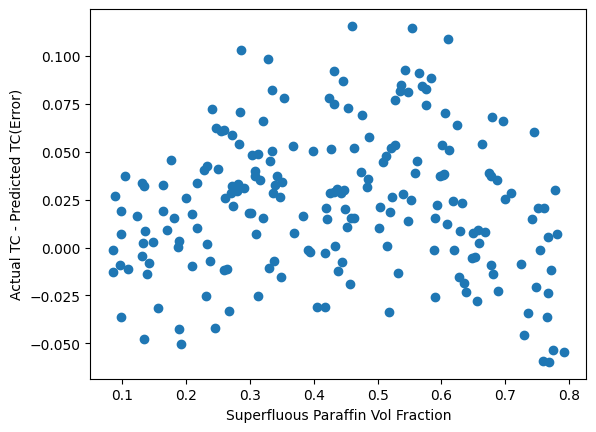

In [43]:
with torch.no_grad():
    actual=actual.to('cpu')
    pred=pred.to('cpu')
    superfluousVolPers=[torch.sum(x[0]).item()/(160*160) for x in test_dataset]
    plt.scatter(superfluousVolPers, (actual-pred))
    plt.xlabel('Superfluous Paraffin Vol Fraction')
    plt.ylabel('Actual TC - Predicted TC(Error)')

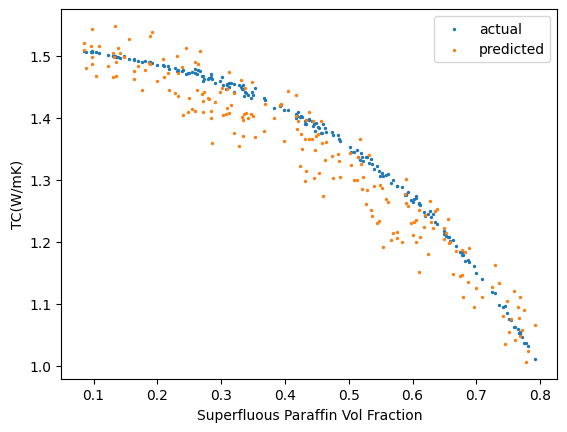

In [44]:
with torch.no_grad():
    plt.scatter(superfluousVolPers, actual, label='actual', s=2)
    plt.scatter(superfluousVolPers, pred, label='predicted', s=2)
    plt.xlabel('Superfluous Paraffin Vol Fraction')
    plt.ylabel('TC(W/mK)')
    plt.legend()

[0.7961659240722656, 0.7967507934570313, 0.7956734466552734, 0.7947026062011718, 0.7941431427001953, 0.7927256011962891, 0.7925934600830078, 0.7913878631591796, 0.7918032073974609, 0.7907488250732422, 0.7896830749511718, 0.7880194854736328, 0.7876584625244141, 0.7874153137207032, 0.7866779327392578, 0.7855860900878906, 0.7844264221191406, 0.7844598388671875, 0.7831632232666016, 0.7826658630371094, 0.7825096893310547, 0.780872573852539, 0.7804904174804688, 0.7795454406738281, 0.7785743713378906, 0.7783094787597656, 0.7780731964111328, 0.775887451171875, 0.7751361846923828, 0.7753070831298828, 0.7736173248291016, 0.7730316162109375, 0.7732080078125, 0.7713025665283203, 0.771162109375, 0.7698149108886718, 0.769359359741211, 0.768846664428711, 0.7683882141113281, 0.7677420806884766, 0.7670374298095703, 0.7662237548828125, 0.7652980804443359, 0.7649835968017578, 0.7637179565429687, 0.7634976959228515, 0.7629361724853516, 0.7616851806640625, 0.7608056640625, 0.7606340026855469, 0.75890708923

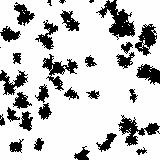

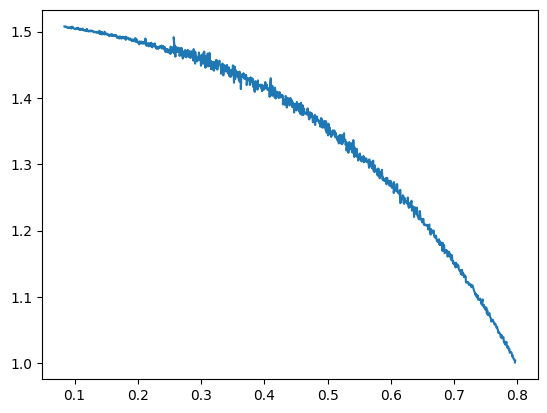

In [148]:
with torch.no_grad():
    dataset.to('cpu')
    spVolPers=[torch.sum(x[0]).item()/(160*160) for x in dataset]
    print(spVolPers)
    display(tensorToImageTransform(dataset[5][0]))
    plt.plot(spVolPers, dataset[:][1])

In [151]:
for i in range(len(conductivities)):
    print(i, spVolPers[i]-volPer[i].item())
print(spVolPers-volPer)
plt.scatter(spVolPers, volPer)

0 -0.0028184247016906916
1 -0.0014914178848266513
2 -0.0017484259605408115
3 -0.00197706937789921
4 -0.0017943358421326217
5 -0.002430639266967738
6 -0.0018205833435058771
7 -0.0022449421882629883
8 -0.0010483598709106756
9 -0.0013605451583862394
10 -0.0016450572013855247
11 -0.0025274085998535645
12 -0.0021462345123290927
13 -0.0016081452369689497
14 -0.0016033291816711648
15 -0.0019139337539673118
16 -0.0022923040390014915
17 -0.0015167498588561923
18 -0.0020320677757262873
19 -0.0017872905731201039
20 -0.00116216659545898
21 -0.002057085037231454
22 -0.0016580033302306951
23 -0.0018217420578002796
24 -0.0020506143569946067
25 -0.0015342688560485707
26 -0.001028354167938228
27 -0.0024328613281250355
28 -0.002441930770874068
29 -0.0014897942543029563
30 -0.0023983144760131303
31 -0.00224182605743406
32 -0.0013232374191284313
33 -0.002447440624237074
34 -0.001806659698486368
35 -0.0024116611480713424
36 -0.0020859742164611728
37 -0.0018564724922179865
38 -0.0015336847305298384
39 -0.00

TypeError: unsupported operand type(s) for -: 'list' and 'Tensor'

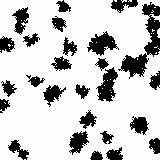

In [147]:
tensorToImageTransform(dataset[4][0])
# torch.sum(dataset[4][0])/(160*160), volPer[4], spVolPers[4]

In [ ]:
class BasicModel(nn.Module):
    def __init__(self):
        super(BasicModel, self).__init__()
        self.seq=nn.Sequential(
            nn.Linear(in_features=1, out_features=10),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=3, out_features=1)
        )

    def forward(self, x):
        return self.seq(x.unsqueeze(1))
    
mlp=BasicModel()

In [68]:
class BasicDataset(Dataset):
    def __init__(self, csv_path):
        with open(csv_path) as f:
            reader=csv.reader(f)
            d=list(reader)
        self.conductivities=torch.tensor(data=[float(x[2]) for x in d[1:]], dtype=torch.float32)
        self.volPer=torch.tensor(data=[float(x[1]) for x in d[1:]], dtype=torch.float32)
    
    def __len__(self):
        return len(self.volPer)
    
    def __getitem__(self, index):
        return self.volPer[index], self.conductivities[index]
    
    def to(self, device):
        self.samples=self.samples.to(device)
        self.conds=self.conds.to(device)
basic_data=BasicDataset('./data/data.csv')
basic_train, basic_test=torch.utils.data.random_split(basic_data, [0.8, 0.2])
basic_data[0]

(tensor(0.7990), tensor(1.0010))

In [69]:
val_loss, train_loss=train_CNN(basic_train, mlp, torch.nn.MSELoss(), torch.optim.Adam(mlp.parameters(), lr=0.001), 300)

0 TRAINING LOSS: 2.1251068399066018 VALIDATION LOSS: 1.9028641138134934
1 TRAINING LOSS: 1.9269582316988991 VALIDATION LOSS: 1.7055740578145515
2 TRAINING LOSS: 1.7329420759564353 VALIDATION LOSS: 1.510698131308323
3 TRAINING LOSS: 1.5317924476805187 VALIDATION LOSS: 1.3201391366196842
4 TRAINING LOSS: 1.341531407265436 VALIDATION LOSS: 1.1363961594860728
5 TRAINING LOSS: 1.1586690005801974 VALIDATION LOSS: 0.9625423921317589
6 TRAINING LOSS: 0.9844997894196283 VALIDATION LOSS: 0.8012141399994129
7 TRAINING LOSS: 0.822779099146525 VALIDATION LOSS: 0.6545338064613866
8 TRAINING LOSS: 0.6771447119258699 VALIDATION LOSS: 0.5250017501686405
9 TRAINING LOSS: 0.5458973078500657 VALIDATION LOSS: 0.41281819730860797
10 TRAINING LOSS: 0.43152945382254465 VALIDATION LOSS: 0.3196433116312752
11 TRAINING LOSS: 0.3388555830433255 VALIDATION LOSS: 0.24465224915349065
12 TRAINING LOSS: 0.2630372515746525 VALIDATION LOSS: 0.18682372193860228
13 TRAINING LOSS: 0.2037576926606042 VALIDATION LOSS: 0.1444

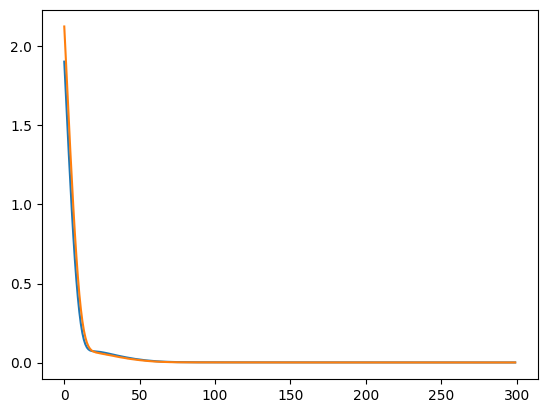

In [70]:
plt.plot(range(300), val_loss)
plt.plot(range(300), train_loss)

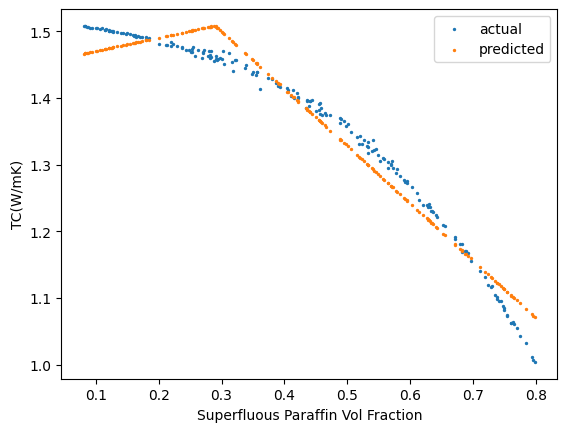

In [84]:
with torch.no_grad():
    pred=mlp(basic_test[:][0]).view(204)
    actual=basic_test[:][1]
    plt.scatter(basic_test[:][0], actual, label='actual', s=2)
    plt.scatter(basic_test[:][0], pred, label='predicted', s=2)
    plt.xlabel('Superfluous Paraffin Vol Fraction')
    plt.ylabel('TC(W/mK)')
    plt.legend()